In [1]:
%matplotlib widget

import os
import sys
import brainweb
import torch
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
import nibabel as nib
import sirf.STIR as stir
msg_red = stir.MessageRedirector('info.txt', 'warnings.txt')
import matplotlib.pyplot as plt
import os
import sirf.Reg as reg
from math import cos, sin, pi, radians
from sirf.Utilities import examples_data_path
#from sirf_exercises import exercises_data_path
import shutil
#from scipy.ndimage.filters import gaussian_filter
from tqdm.auto import tqdm
# add the source directory to the path
# This is to make everything nice and self-contained
dir_path = os.path.dirname(os.getcwd())
source_path = os.path.join(dir_path, 'source')
sys.path.append(source_path)
from data.ellipses import EllipsesDataset
from reconstruction.reconstruction import *
from reconstruction.registration import *
from reconstruction.osem import *
from plotting_functions import plot_2d_image
import matplotlib.pyplot as plt
import imageio
from plotting_functions import *
from IPython.display import Image
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

msg_red = stir.MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')
# load model 
path_to_data = os.path.join(os.path.dirname(os.getcwd()), 'source', 'models')
sys.path.append(path_to_data)

# reconstruction
import os
import sirf.STIR as stir
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_erosion
from sirf.STIR import AcquisitionModelUsingParallelproj
import os
import sirf.STIR as stir
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import shift
import os
import sirf.STIR as stir
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_erosion
from sirf.STIR import AcquisitionModelUsingParallelproj



In [2]:
# Reconstruction for one slice

def compute_rmse(pred, gt):
    return np.sqrt(np.mean((pred - gt) ** 2)) 

dir_path = os.path.dirname(os.getcwd())
test_dir = '/home/sirfuser/shared/ft_test/'
pred_dir = os.path.join(dir_path, 'data', 'new_ft_diff')
data_path = os.path.join(dir_path, 'data', 'template_data')

subject_idx = 2
slice_idx = 4

emis_path = os.path.join(test_dir, f'emission_{subject_idx}_{slice_idx}.hv')
sens_path = os.path.join(test_dir, f'sens_{subject_idx}_{slice_idx}.hv')
trans_emis_path = os.path.join(test_dir, f'transform_emission_{subject_idx}_{slice_idx}.hv')
trans_attn_path = os.path.join(test_dir, f'transform_attn_{subject_idx}_{slice_idx}.hv')
trans_sens_path = os.path.join(test_dir, f'transform_sens_{subject_idx}_{slice_idx}.hv')
pred_sens_path = os.path.join(pred_dir, f'pred_sens_{subject_idx}_{slice_idx}.hv')
template_sino_path = os.path.join(data_path, 'template_sinogram.hs')

emis = stir.ImageData(emis_path)
sens = stir.ImageData(sens_path)
trans_emis = stir.ImageData(trans_emis_path)
trans_attn = stir.ImageData(trans_attn_path)
trans_sens = stir.ImageData(trans_sens_path)
pred_sens = stir.ImageData(pred_sens_path)
template_sinogram = stir.AcquisitionData(template_sino_path)


emis /= 100 
trans_emis /= 100 

num_subsets = 1
num_epochs = 20

acq_model = get_acquisition_model(emis, template_sinogram, trans_attn, num_subsets)
proj_data = get_acquired_data(emis, acq_model, noise_factor=0.01)

initial_image = emis.get_uniform_copy(emis.as_array().mean())
cyl = stir.TruncateToCylinderProcessor()
cyl.set_strictly_less_than_radius(True)
cyl.apply(initial_image)

radon = stir.AcquisitionModelUsingRayTracingMatrix()
radon.set_num_tangential_LORs(10)
radon.num_subsets = 1
radon.set_up(template_sinogram, emis)
     
pred_recon = osem_reconstruction(initial_image.clone(), radon, acquired_data=[proj_data], num_subsets=num_subsets, num_epochs=num_epochs, sensitivity_images=[pred_sens], transform_matrices=None, resample=False)
misaligned_recon = osem_reconstruction(initial_image.clone(), radon, acquired_data=[proj_data], num_subsets=num_subsets, num_epochs=num_epochs, sensitivity_images=[sens], transform_matrices=None, resample=False)
aligned_recon = osem_reconstruction(initial_image.clone(), radon, acquired_data=[proj_data], num_subsets=num_subsets, num_epochs=num_epochs, sensitivity_images=[trans_sens], transform_matrices=None, resample=False)

pred_recon_array = pred_recon.as_array()[0]
aligned_array = aligned_recon.as_array()[0]
misaligned_array = misaligned_recon.as_array()[0]

rmse_pred = compute_rmse(pred_recon_array, aligned_array)
norm_rmse = rmse_pred/(np.mean(aligned_array) + 1e-8)
print(f"Predicted Sensitivity Recon RMSE: {rmse_pred:.4f}")



no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

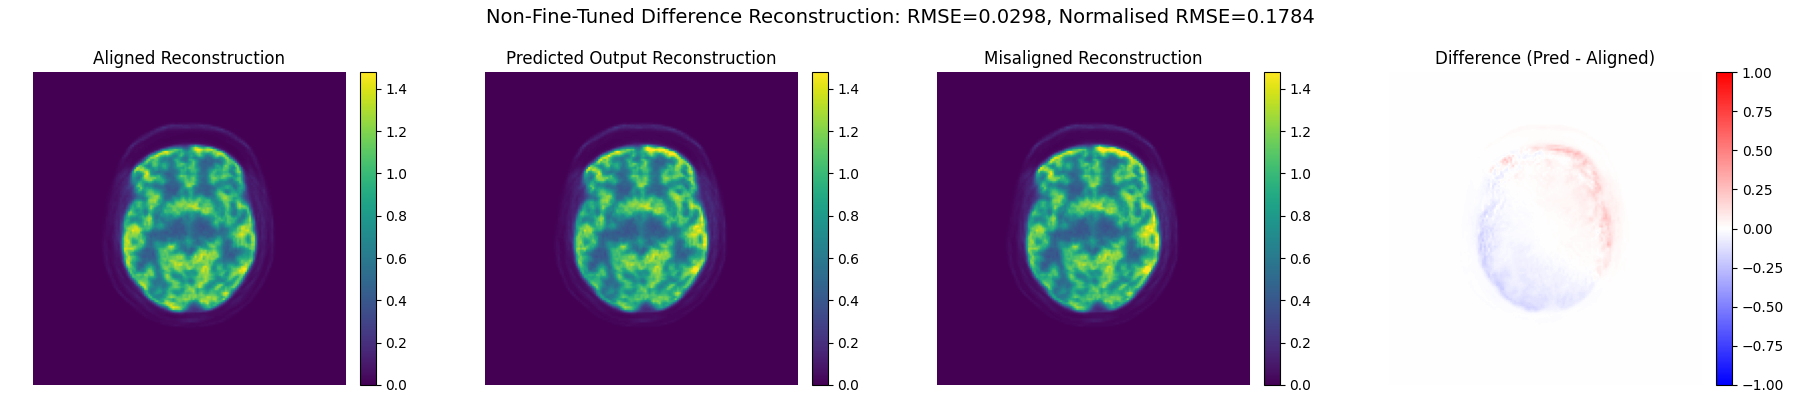

In [3]:
# Compute difference map
diff_map = pred_recon_array - aligned_array
diff_max = np.max(np.abs(diff_map)) 

# Shared vmin/vmax for reconstructions
vmin = aligned_array.min()
vmax = aligned_array.max()

# Plots
plt.figure(figsize=(18, 4))

plt.subplot(1, 4, 1)
im1 = plt.imshow(aligned_array, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Aligned Reconstruction")
plt.axis('off')
plt.colorbar(im1, fraction=0.046, pad=0.04)

# Reconstruction using predicted sensitivity image
plt.subplot(1, 4, 2)
im2 = plt.imshow(pred_recon_array, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Predicted Output Reconstruction")
plt.axis('off')
plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.subplot(1, 4, 3)
im3 = plt.imshow(misaligned_array, cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Misaligned Reconstruction")
plt.axis('off')
plt.colorbar(im3, fraction=0.046, pad=0.04)

# Difference map (Predicted - Aligned)
plt.subplot(1, 4, 4)
im4 = plt.imshow(diff_map, cmap='bwr', vmin=-1, vmax=1)
plt.title("Difference (Pred - Aligned)")
plt.axis('off')
plt.colorbar(im4, fraction=0.046, pad=0.04)

fig = plt.gcf()
fig.suptitle(
    f"Non-Fine-Tuned Difference Reconstruction: "
    f"RMSE={rmse_pred:.4f}, Normalised RMSE={norm_rmse:.4f}",
    fontsize=14,
    x=0.5

)

plt.tight_layout(rect=[0, 0, 1, 0.9]) 
plt.subplots_adjust(top=0.82, wspace=0.25) 
plt.show()


In [69]:
# Calculate RMSE over whole test set 

def compute_rmse(pred, gt):
    return np.sqrt(np.mean((pred - gt) ** 2))

dir_path = os.path.dirname(os.getcwd())
test_dir = '/home/sirfuser/shared/ft_test/'
pred_dir = os.path.join(dir_path, 'data', 'new_ft_ratio_median')
data_path = os.path.join(dir_path, 'data', 'template_data')

num_slices = 5
test_subjects = [2, 6, 11, 17]

total_rmse = 0.0
total_norm_rmse = 0.0
count = 0

for subject in test_subjects:
    for slice_idx in range(1, num_slices + 1): 
        emis_path = os.path.join(test_dir, f'emission_{subject}_{slice_idx}.hv')
        sens_path = os.path.join(test_dir, f'sens_{subject}_{slice_idx}.hv')
        trans_emis_path = os.path.join(test_dir, f'transform_emission_{subject}_{slice_idx}.hv')
        trans_attn_path = os.path.join(test_dir, f'transform_attn_{subject}_{slice_idx}.hv')
        trans_sens_path = os.path.join(test_dir, f'transform_sens_{subject}_{slice_idx}.hv')
        pred_sens_path = os.path.join(pred_dir, f'pred_sens_{subject}_{slice_idx}.hv')
        template_sino_path = os.path.join(data_path, 'template_sinogram.hs')

        emis = stir.ImageData(emis_path)
        sens = stir.ImageData(sens_path)
        trans_emis = stir.ImageData(trans_emis_path)
        trans_attn = stir.ImageData(trans_attn_path)
        trans_sens = stir.ImageData(trans_sens_path)
        pred_sens = stir.ImageData(pred_sens_path)
        template_sinogram = stir.AcquisitionData(template_sino_path)
        
        emis /= 100 
        trans_emis /= 100 
        
        num_subsets = 1
        num_epochs = 20
        
        acq_model = get_acquisition_model(emis, template_sinogram, trans_attn, num_subsets)
        proj_data = get_acquired_data(emis, acq_model, noise_factor=0.01)
        
        initial_image = emis.get_uniform_copy(emis.as_array().mean())
        cyl = stir.TruncateToCylinderProcessor()
        cyl.set_strictly_less_than_radius(True)
        cyl.apply(initial_image)
        
        radon = stir.AcquisitionModelUsingRayTracingMatrix()
        radon.set_num_tangential_LORs(10)
        radon.num_subsets = 1
        radon.set_up(template_sinogram, emis)
             
        pred_recon = osem_reconstruction(initial_image.clone(), radon, acquired_data=[proj_data], num_subsets=num_subsets, num_epochs=num_epochs, sensitivity_images=[pred_sens], transform_matrices=None, resample=False)
        misaligned_recon = osem_reconstruction(initial_image.clone(), radon, acquired_data=[proj_data], num_subsets=num_subsets, num_epochs=num_epochs, sensitivity_images=[sens], transform_matrices=None, resample=False)
        aligned_recon = osem_reconstruction(initial_image.clone(), radon, acquired_data=[proj_data], num_subsets=num_subsets, num_epochs=num_epochs, sensitivity_images=[trans_sens], transform_matrices=None, resample=False)
        
        pred_recon_array = pred_recon.as_array()[0]
        aligned_array = aligned_recon.as_array()[0]
        misaligned_array = misaligned_recon.as_array()[0]

        # compute RMSEs
        rmse_val = compute_rmse(pred_recon_array, aligned_array)
        norm_rmse_val = rmse_val / (np.mean(aligned_array) + 1e-8)

        total_rmse += rmse_val
        total_norm_rmse += norm_rmse_val
        count += 1

        print(f"Subject {subject}, Slice {slice_idx} -> "
              f"RMSE: {rmse_val:.4f}, Normalised RMSE: {norm_rmse_val:.4f}")


# global averages
avg_rmse = total_rmse / count
avg_norm_rmse = total_norm_rmse / count

print(f"\nAverage RMSE across test set: {avg_rmse:.4f}")
print(f"Average Normalised RMSE across test set: {avg_norm_rmse:.4f}")

normalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
bac

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background ter